In this section , the **historical** data of **AAPL** **NASDAQ** and **S&P500** is combined into a single dataframe and closing price of all three are plotted.

<IPython.core.display.Javascript object>


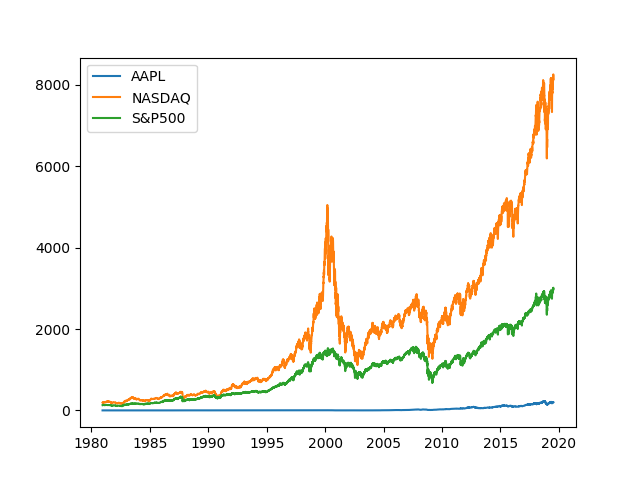

C:\Users\mirza\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


,Open,High,Low,AAPL,Volume,NOpen,NHigh,NLow,NASDAQ,NVolume,SOpen,SHigh,SLow,S&P500,SVolume
Date,,,,,,,,,,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.410525,117258400,191.220001,191.220001,191.220001,191.220001,353630000.0,127.360001,129.979996,127.150002,129.229996,39530000
1980-12-15,0.488839,0.488839,0.486607,0.389106,43971200,194.020004,194.020004,194.020004,194.020004,353630000.0,129.229996,131.330002,128.639999,129.449997,39700000
1980-12-16,0.453125,0.453125,0.450893,0.360548,26432000,191.880005,191.880005,191.880005,191.880005,353630000.0,129.449997,131.220001,128.330002,130.600006,41630000
1980-12-17,0.462054,0.464286,0.462054,0.369472,21610400,194.020004,194.020004,194.020004,194.020004,353630000.0,130.600006,133.589996,130.220001,132.889999,50800000
1980-12-18,0.475446,0.477679,0.475446,0.380182,18362400,196.009995,196.009995,196.009995,196.009995,353630000.0,132.889999,135.899994,131.889999,133.000000,69570000


In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df1=pd.read_csv('data/AAPL.csv',index_col='Date',parse_dates=True)
df1=df1.drop(columns='Close')
df1.rename(columns={'Adj Close':'AAPL'},inplace=True)
df0=pd.read_csv('data/NASDAQ.csv',index_col=['Date'],parse_dates=True)
df0=df0.drop(columns='Close')
df0.rename(columns={'Adj Close':'NASDAQ','Open':'NOpen','High':'NHigh','Low':'NLow','Volume':'NVolume'},inplace=True)
df0.loc[df0['NVolume']==0,'NVolume']=df0.NVolume.median()
df2=pd.read_csv('data/S&P500.csv',index_col=['Date'],parse_dates=True)
df2=df2.drop(columns='Close')
df2.rename(columns={'Adj Close':'S&P500','Open':'SOpen','High':'SHigh','Low':'SLow','Volume':'SVolume'},inplace=True)
df3=df1.join(df0)
df1=df3.join(df2)
plt.plot(df1.AAPL,label='AAPL')
plt.plot(df1.NASDAQ,label='NASDAQ')
plt.plot(df1['S&P500'],label='S&P500')
plt.legend()
plt.show()
df1.head()

Correlation between the closing price of **AAPL**,**NASDAQ** and **S&P500** is calculated and analysed to confirm the interdependence between their prices

<IPython.core.display.Javascript object>


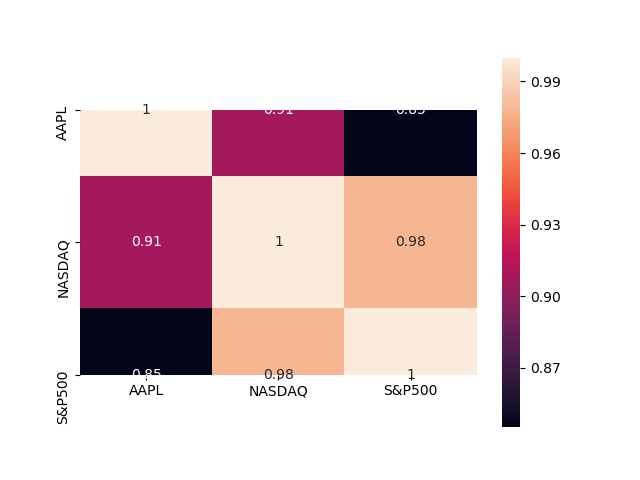

In [2]:
%matplotlib notebook
import seaborn as sns
sns.heatmap(df1[['AAPL','NASDAQ','S&P500']].corr(),annot=True,square=True)

In [4]:
 from sklearn.model_selection import TimeSeriesSplit
def daily_returns(df):
    df03=df.copy()
    df03[1:]=(df[1: ]/df[ :-1].values)-1
    df03.iloc[0]=0
    return df03

    
def z_score(x):
    return (x-x.mean())/x.std()
def normalize(df):
    return df/df.iloc[0]
def momentumW(df):
    return df/df.shift(5)-1
def momentum3M(df):
    return df/df.shift(60)-1
def momentumY(df):
    return df/df.shift(240)-1
def bollingerbands(df):
    mean=df.rolling(window=20).mean()
    std=df.rolling(window=20).std()
    ub=mean+std*2
    lb=mean-std*2
    return ub,lb
def FILLNA(df,param):
    flag=0
    pdf=pd.DataFrame(index=df.index)
    for i in df:
        if i!='day' and i!='week' and i!='month':
            if param=="mean":
                pdf[i]=df[i].fillna(df[i].mean())
            elif(param=="median"):
                pdf[i]=df[i].fillna(df[i].median())
            else:
                flag=1
        else:
            pdf[i]=df[i]
        if flag==1:
            print('invalid param')
            break
    return pdf
def FeatureSelector(param,x,y):
    y=y+0.0000001
    x=x-0.0000001
    lb=corr.loc[corr[param] >x,param]
    ub=corr.loc[corr[param] <y,param]
    lb1=corr.loc[corr[param] <-x,param]
    ub1=corr.loc[corr[param] >-y,param]
    y1=lb-ub
#     print(lb)
#     print(ub)
#     print(y1)
    y1=y1.dropna()
#     print(y1)
    z=lb1-ub1
#     print(z)
    z=z.dropna()
#     print(z)
    z1=y1+z
#     print(z1)
    return z1.index
def mark(df):
    arr=[]
    for i in df:
        if i>0:
            arr.append(1)
        elif i<=0:
            arr.append(-1)
        else:
            arr.append(0)
    return np.array(arr)

def cross_val_score1(clf,X,Y,cv):#cross validation for timeseries data
    score=[] 
    tscv=TimeSeriesSplit(n_splits=cv)
    for train_ind,test_ind in tscv.split(X):
#         print(train_ind,test_ind)
        xtrain,xtest=X[train_ind],X[test_ind]
        ytrain,ytest=Y[train_ind],Y[test_ind]
        clf.fit(xtrain,ytrain)
        z=float(clf.score(xtest,ytest))

        score.append(z)

    return np.array(score)
    

Further, the normalized value of closing prices of **AAPL**,**NASDAQ** and **S&P500** are plotted and we can clearly see the matching patterns

<IPython.core.display.Javascript object>


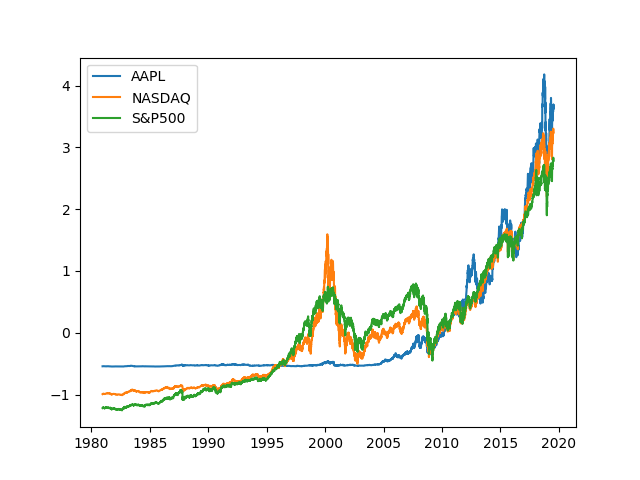

In [5]:
%matplotlib notebook
plt.plot(z_score(df1.AAPL),label="AAPL")
plt.plot(z_score(df1.NASDAQ),label="NASDAQ")
plt.plot(z_score(df1['S&P500']),label='S&P500')
plt.legend()
plt.show()

Using some of the technical indicators ,we derive the new features from the existing features.And later using correlation between features,we do feature selection to rule out less important features


In [6]:
%matplotlib notebook
f=pd.DataFrame(index=df1.index).sort_index()
f['open']=df1.Open
f['high']=df1.High
f['low']=df1.Low
f['close']=df1.AAPL
f['volume']=df1.Volume
f['NASDAQ']=df1.NASDAQ
f['S&P500']=df1['S&P500']



<IPython.core.display.Javascript object>


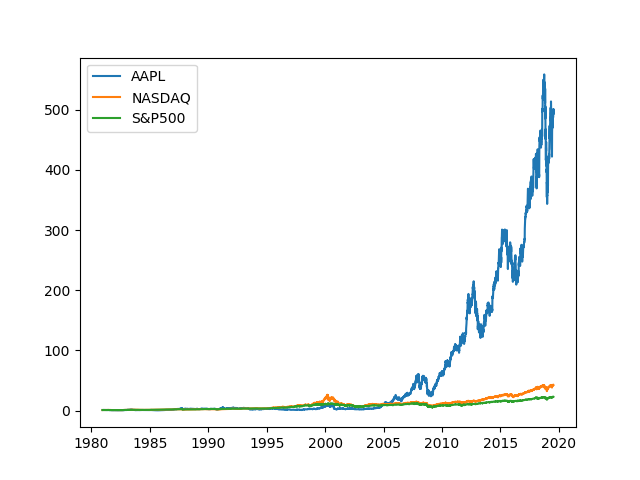

In [7]:
%matplotlib notebook
f['01']=normalize(df1.AAPL)
f['02']=normalize(df1.NASDAQ)
f['03']=normalize(df1['S&P500'])
plt.plot(f['01'],label="AAPL")
plt.plot(f['02'],label="NASDAQ")
plt.plot(f['03'],label='S&P500')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


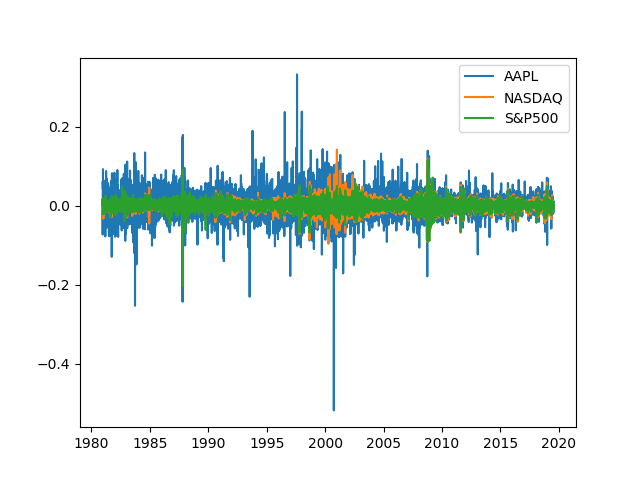

In [8]:
%matplotlib notebook
f['DRS']=daily_returns(df1['AAPL'])
f['DRN']=daily_returns(df1['NASDAQ'])
f['DRSP']=daily_returns(df1['S&P500'])
plt.plot(f['DRS'],label="AAPL")
plt.plot(f['DRN'],label='NASDAQ')
plt.plot(f['DRSP'],label='S&P500')
plt.legend()
plt.show()







<IPython.core.display.Javascript object>


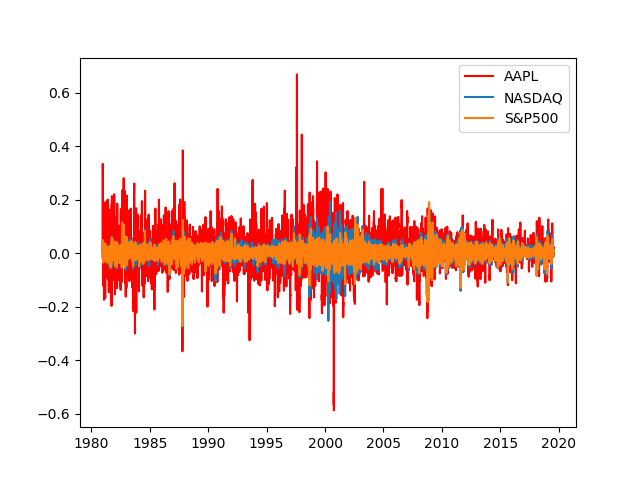

In [9]:
%matplotlib notebook
f['MoAW']=momentumW(df1.AAPL)
f['MoNW']=momentumW(df1.NASDAQ)
f['MoSW']=momentumW(df1['S&P500'])
plt.plot(f['MoAW'],label="AAPL",color='r')
plt.plot(f['MoNW'],label='NASDAQ')
plt.plot(f['MoSW'],label='S&P500')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


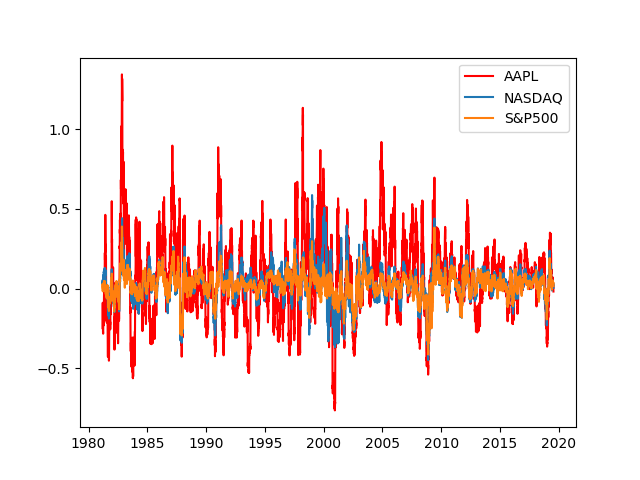

In [10]:
%matplotlib notebook
f['MoAQ']=momentum3M(df1.AAPL)
f['MoNQ']=momentum3M(df1.NASDAQ)
f['MoSQ']=momentum3M(df1['S&P500'])
plt.plot(f['MoAQ'],label="AAPL",color='r')
plt.plot(f['MoNQ'],label='NASDAQ')
plt.plot(f['MoSQ'],label='S&P500')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


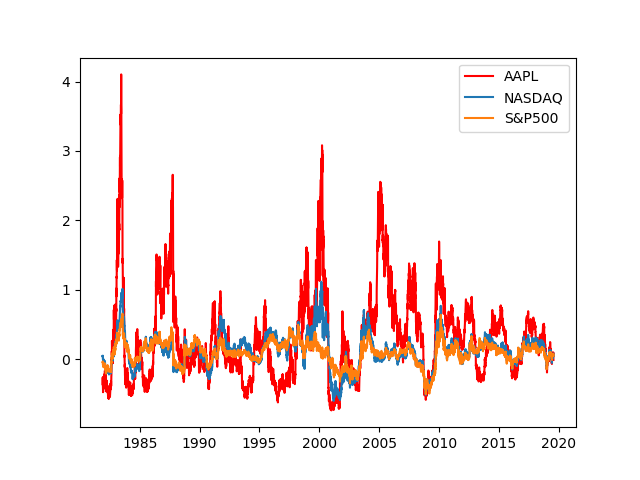

In [11]:
%matplotlib notebook
f['MoAY']=momentumY(df1.AAPL)
f['MoNY']=momentumY(df1.NASDAQ)
f['MoSY']=momentumY(df1['S&P500'])
plt.plot(f['MoAY'],label="AAPL",color='r')
plt.plot(f['MoNY'],label='NASDAQ')
plt.plot(f['MoSY'],label='S&P500')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


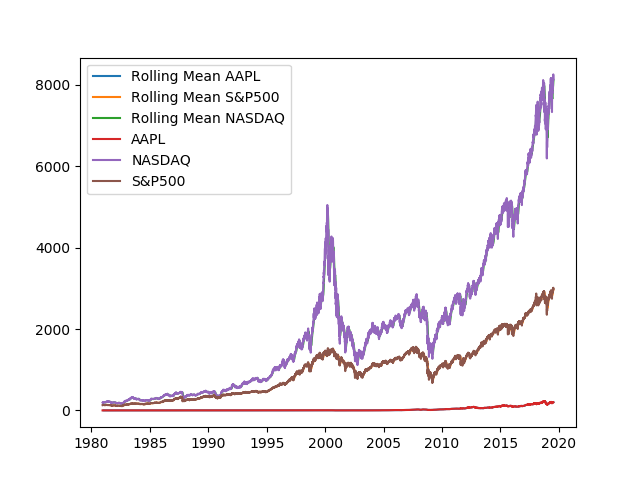

In [12]:
%matplotlib notebook
f['RMA']=df1.AAPL.rolling(window=20).mean()
f['RMN']=df1.NASDAQ.rolling(window=20).mean()
f['RMS']=df1['S&P500'].rolling(window=20).mean()
plt.plot(f['RMA'],label='Rolling Mean AAPL')
plt.plot(f['RMS'],label='Rolling Mean S&P500')
plt.plot(f['RMN'],label='Rolling Mean NASDAQ')
plt.plot(df1.AAPL,label='AAPL')
plt.plot(df1.NASDAQ,label='NASDAQ')
plt.plot(df1['S&P500'],label='S&P500')
plt.legend()


<IPython.core.display.Javascript object>


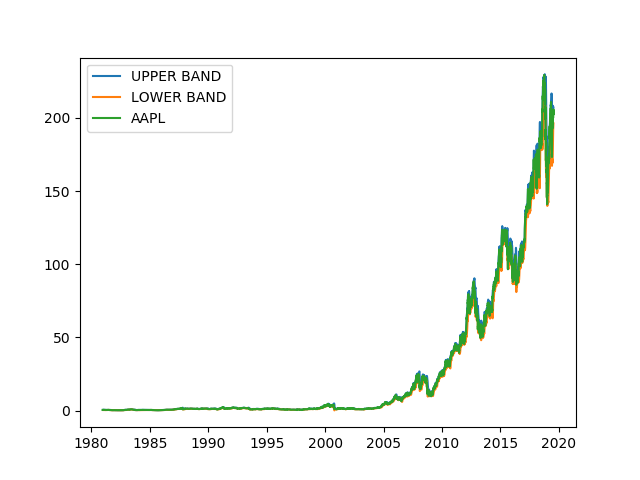

In [13]:
%matplotlib notebook
ub,lb=(bollingerbands(df1.AAPL))
plt.plot(ub,label="UPPER BAND")
plt.plot(lb,label="LOWER BAND")
plt.plot(df1.AAPL,label="AAPL")
plt.legend()
f['UBA']=ub
f['LBA']=lb

<IPython.core.display.Javascript object>


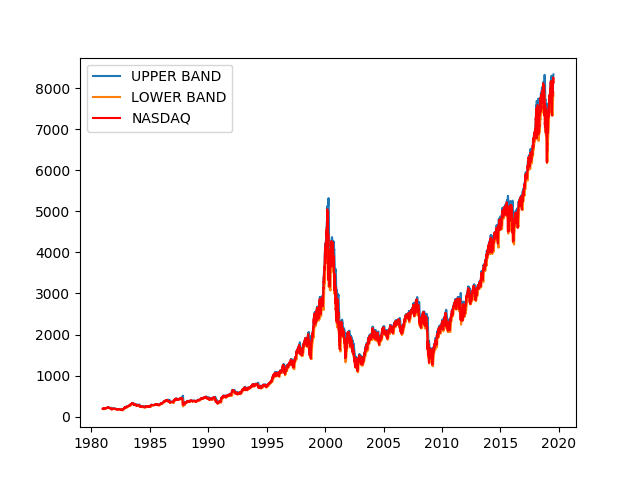

In [14]:
%matplotlib notebook
ubN,lbN=(bollingerbands(df1.NASDAQ))
plt.plot(ubN,label="UPPER BAND")
plt.plot(lbN,label="LOWER BAND")
plt.plot(df1.NASDAQ,label="NASDAQ",color='r')
plt.legend()
f['UBN']=ubN
f['LBN']=lbN

<IPython.core.display.Javascript object>


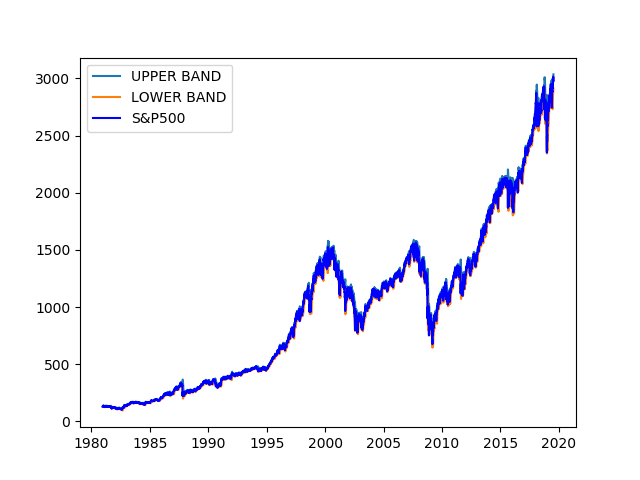

In [15]:
%matplotlib notebook
ubS,lbS=(bollingerbands(df1['S&P500']))
plt.plot(ubS,label="UPPER BAND")
plt.plot(lbS,label="LOWER BAND")
plt.plot(df1['S&P500'],label="S&P500",color='b')
plt.legend()
f['UBS']=ubS
f['LBS']=lbS

In [16]:
f['f01']=df1.AAPL/df1.Open-1
f['f02']=df1.Open/df1.AAPL.shift(-1)-1
f['f20']=(df1.AAPL-df1.Open)/df1.Open
f['f03']=df1.Volume/df1.Volume[0]
f['f04']=f.f03/f.f03.shift(-1) -1
f['std']=df1.AAPL.rolling(window=20).std()




In [17]:
f['f01N']=df1.NASDAQ/df1.NOpen-1
f['f02N']=df1.NOpen/df1.NASDAQ.shift(-1)-1
f['f20N']=(df1.NASDAQ-df1.NOpen)/df1.NOpen
f['f03N']=df1.NVolume/df1.NVolume[0]
f['f04N']=f.f03N.shift(-1)-f.f03N
f['stdN']=df1.NASDAQ.rolling(window=20).std()


In [18]:
f['f01S']=df1['S&P500']/df1.SOpen-1
f['f02S']=df1.SOpen/df1['S&P500'].shift(-1)-1
f['f20S']=(df1['S&P500']-df1.SOpen)/df1.SOpen
f['f03S']=df1.SVolume/df1.SVolume[0]
f['f04S']=f.f03S.shift(-1)-f.f03S
f['stdS']=df1['S&P500'].rolling(window=20).std()

In [19]:
f['day']=df1.AAPL.shift(-1)
f['week']=df1.AAPL.shift(-5)
f['month']=df1.AAPL.shift(-24)
f['DailyR']=daily_returns(f.close).shift(-1)
f.head()

,open,high,low,close,volume,NASDAQ,S&P500,01,02,03,...,f01S,f02S,f20S,f03S,f04S,stdS,day,week,month,DailyR
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.410525,117258400,191.220001,129.229996,1.000000,1.000000,1.000000,...,0.014683,-0.016145,0.014683,1.000000,0.004301,NaN,0.389106,0.403385,0.469426,-0.052175
1980-12-15,0.488839,0.488839,0.486607,0.389106,43971200,194.020004,129.449997,0.947825,1.014643,1.001702,...,0.001702,-0.010490,0.001702,1.004301,0.048824,NaN,0.360548,0.423019,0.455147,-0.073394
1980-12-16,0.453125,0.453125,0.450893,0.360548,26432000,191.880005,130.600006,0.878261,1.003452,1.010601,...,0.008884,-0.025886,0.008884,1.053124,0.231976,NaN,0.369472,0.440868,0.464072,0.024751
1980-12-17,0.462054,0.464286,0.462054,0.369472,21610400,194.020004,132.889999,0.899999,1.014643,1.028322,...,0.017534,-0.018045,0.017534,1.285100,0.474829,NaN,0.380182,0.464072,0.469426,0.028987
1980-12-18,0.475446,0.477679,0.475446,0.380182,18362400,196.009995,133.000000,0.926087,1.025050,1.029173,...,0.000828,-0.006058,0.000828,1.759929,-0.475588,NaN,0.403385,0.506909,0.467641,0.061031


NULL values are removed and the data is normalized for better results


In [21]:
fb=FILLNA(f.drop(columns=['day','week','month','DailyR']),'median')
fb=z_score(fb)
test=fb[-30:]
fbb=fb[:-30]#last 30 days of data is left out for later on testing the model.

<IPython.core.display.Javascript object>


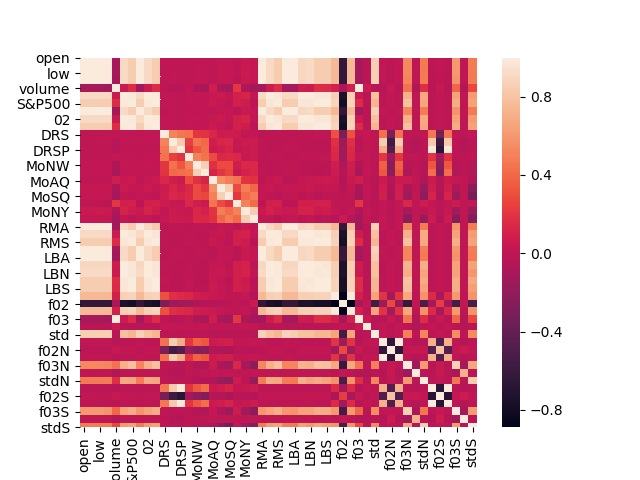

In [23]:
%matplotlib notebook
import seaborn as sns
corr=fb.corr()
sns.heatmap(corr)




In [30]:
#The correlation values must be tuned properly
#correlation of 1 actually means same information so we are dropping those features to avaoid duplicate features
#Highest accuracy will be attained if features with high correlation are selected
fz=FeatureSelector('close',0.1,0.9)#features having correlation(0.1 to 0.9 and -0.1 to(-0.9 ) with close(AAPL)
no_features=len(fz)
print("Number of features for predicting price:",no_features)
fc=FeatureSelector('DRS',0.2,0.7)#features having correlation(0.2 to 0.7 and -0.2 to(-0.7) ) with daily returns(AAPL)
print("Number of features for predicting movement",len(fc))


Number of features for predicting price: 16
Number of features for predicting movement 13


We form a datarame of selected features for predicting price(Regression model)

<IPython.core.display.Javascript object>


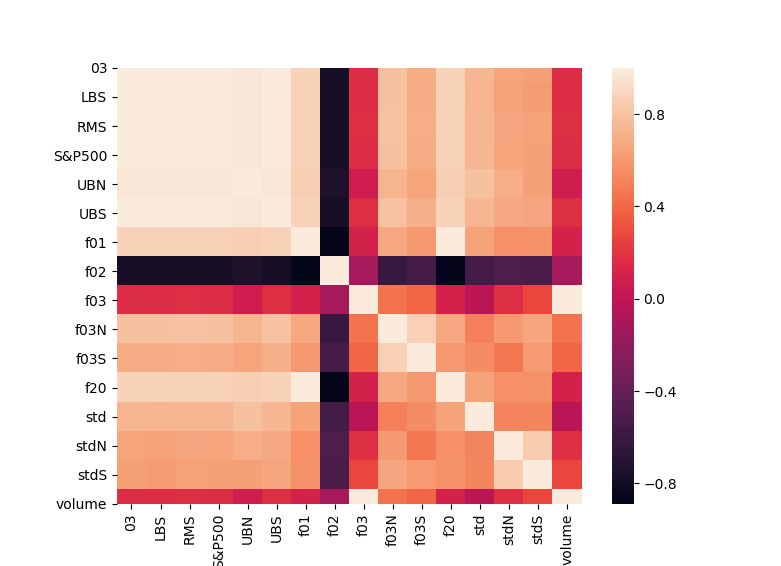

In [33]:
%matplotlib notebook
selectedF=pd.DataFrame(index=fbb.index)
stest=pd.DataFrame(index=test.index)
for i in fz:
    selectedF[i]=(fbb[i])
    
corrF=selectedF.corr()
sns.heatmap(corrF,square=True,annot=False)   
for i in fz:
    stest[i]=(test[i])


    

We form a datarame of selected features for predicting movement(Classification model)

<IPython.core.display.Javascript object>


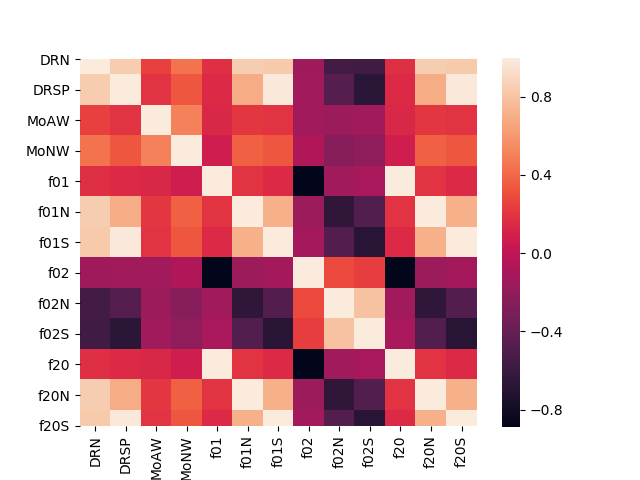

In [42]:
%matplotlib notebook
selectedFC=pd.DataFrame(index=fb.index)
for i in fc:
    selectedFC[i]=(fb[i])
selectedFC=selectedFC[:-1]
corrFC=selectedFC.corr()
sns.heatmap(corrFC,square=True,annot=False) 


    

In [36]:
#labels for regression(we only chose one at a time)
label=pd.DataFrame(index=selectedF.index)
label['day']=f.day#abel for predicting price on next day
label['week']=f.week# label for predicting price after 5 days
#select either one accordingly
label.head()

,day,week
Date,,
1980-12-12,0.389106,0.403385
1980-12-15,0.360548,0.423019
1980-12-16,0.369472,0.440868
1980-12-17,0.380182,0.464072
1980-12-18,0.403385,0.506909


In [39]:
label1=pd.DataFrame(index=selectedFC.index)
label1['DailyR']=daily_returns(f.close).shift(-1)
#mark function defined above will mark 1 for positive value and -1 for negative values
label1['DailyRE']=mark(label1['DailyR'])#label for classification
label1.head()

,DailyR,DailyRE
Date,,
1980-12-12,-0.052175,-1
1980-12-15,-0.073394,-1
1980-12-16,0.024751,1
1980-12-17,0.028987,1
1980-12-18,0.061031,1


<IPython.core.display.Javascript object>


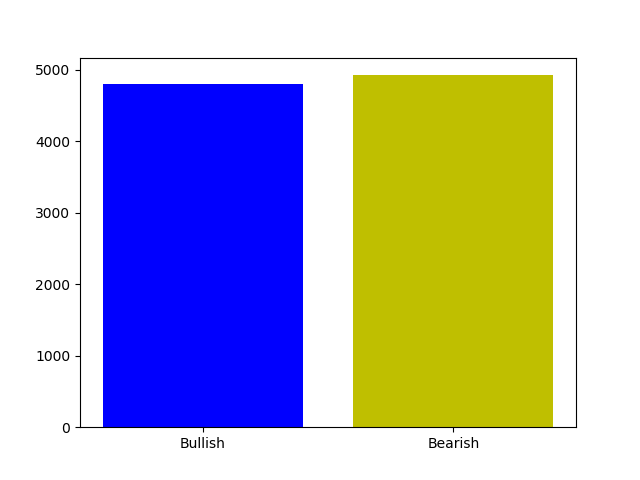

<BarContainer object of 2 artists>

In [51]:
%matplotlib notebook
x=len(label1[label1['DailyRE'] ==1])
y=len(label1[label1['DailyRE'] ==-1])
plt.bar(['Bullish','Bearish'],[x,y],color='by')

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
%matplotlib notebook
X=np.array(z_score(selectedF))
Y=np.array((label['day']))
xt,xte,yt,yte=train_test_split(X,Y)

Now In this section accuracy and rolling cross validation of regression approach is calculated.Also using the model we predict the prices of next 30 days.Note that the data of this time period() is not shown to model.

Accuracy =  0.9915859068723937


<IPython.core.display.Javascript object>


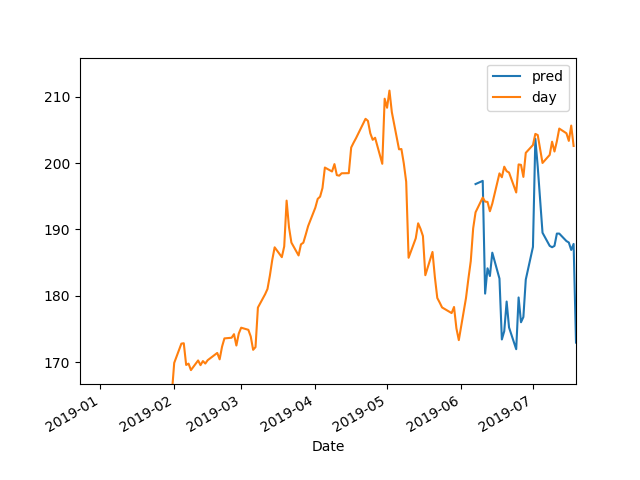

Rolling Cross Validation =  [-0.96586857 -0.40993447 -5.31462158 -1.51873583 -0.53541324 -2.70421224
 -6.77501198 -0.72858407]


In [53]:
from sklearn import neighbors
clf=neighbors.KNeighborsRegressor()
clf.fit(xt,yt)
print("Accuracy = ",clf.score(xte,yte))
pred=clf.predict(stest)
pd4=pd.DataFrame(pred,index=stest.index,columns=['pred'])
pd4=pd4.join(f.day,how='outer')
pd4.plot()
result=cross_val_score1(clf,X,Y,8)
print("Rolling Cross Validation = ",result)

C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy=  0.9983913751816718


<IPython.core.display.Javascript object>


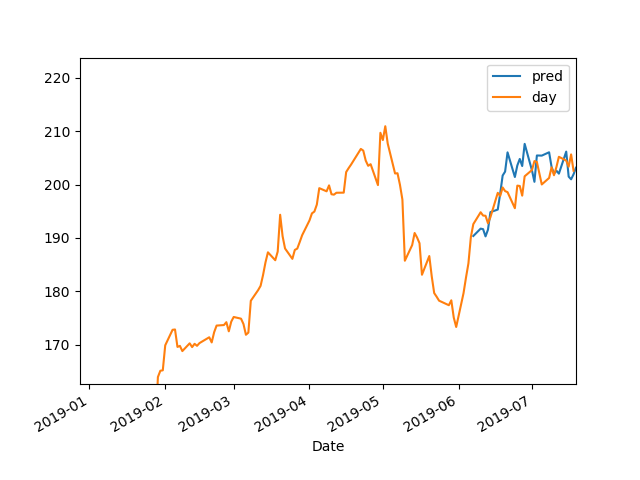

Rolling cross validation : [-1.38011985e-01  3.12289076e-03 -4.53297509e-01 -1.22361460e+00
 -5.22797854e-01 -2.59794111e+00 -6.46062375e+00 -6.17710420e-01]


In [55]:
from sklearn.ensemble import RandomForestRegressor
clf=RandomForestRegressor()
clf.fit(xt,yt)
print("accuracy= ",clf.score(xte,yte))
pred=clf.predict(stest)
pd4=pd.DataFrame(pred,index=stest.index,columns=['pred'])
pd4=pd4.join(f.day,how='outer')
pd4.plot()
result=cross_val_score1(clf,X,Y,8)
print("Rolling cross validation :",result)


Accuracy=  0.9441307453936455


<IPython.core.display.Javascript object>


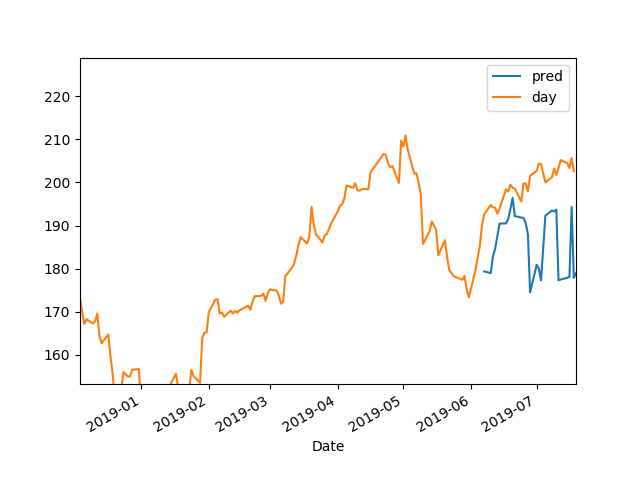

Rolling Cross Validation : [ -0.08068671  -2.14969823 -27.97093854 -11.458925     0.18312927
  -0.2807614   -3.08989513  -0.13628645]


In [57]:
from sklearn.linear_model import LinearRegression
clf= LinearRegression()
clf.fit(xt,yt)
print("Accuracy= ",clf.score(xte,yte))
pred=np.array(clf.predict(stest))
pd4=pd.DataFrame(pred,index=stest.index,columns=['pred'])
pd4=pd4.join(f.day,how='outer')
pd4.plot()
result=cross_val_score1(clf,X,Y,8)
print("Rolling Cross Validation :",result)

Accuracy=  0.9441458029866759


<IPython.core.display.Javascript object>


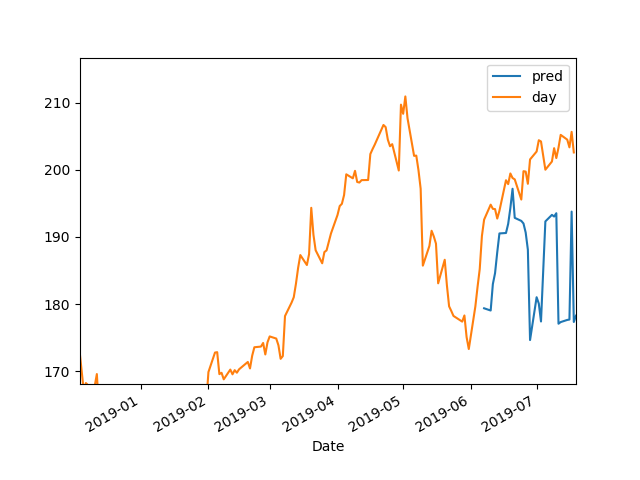

Rolling Cross Validation : [ 8.88703126e-03 -1.09048947e+00 -3.87097547e+01 -8.57890337e+00
  6.40602129e-02 -3.33178566e-01 -3.07575973e+00 -1.42789474e-01]


In [59]:
%matplotlib notebook
from sklearn.linear_model import Ridge
clf= Ridge()
clf.fit(xt,yt)
print("Accuracy= ",clf.score(xte,yte))
pred=np.array(clf.predict(stest))
pd4=pd.DataFrame(pred,index=stest.index,columns=['pred'])
pd4=pd4.join(f.day,how='outer')
pd4.plot()

result=cross_val_score1(clf,X,Y,8)
print("Rolling Cross Validation :",result)


Accuracy=  0.9264978950006072


<IPython.core.display.Javascript object>


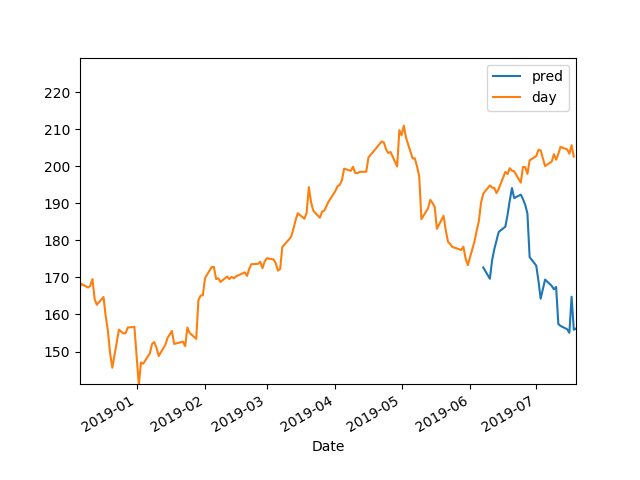

Rolling Cross Validation : [-1.14850325 -6.45361129 -0.01791449 -0.78428689 -0.74785113 -5.49103451
 -8.69453784 -1.39692142]


In [60]:
from sklearn.linear_model import Lasso
clf= Lasso()
clf.fit(xt,yt)
print("Accuracy= ",clf.score(xte,yte))
pred=np.array(clf.predict(stest))
pd4=pd.DataFrame(pred,index=stest.index,columns=['pred'])
pd4=pd4.join(f.day,how='outer')
pd4.plot()
result=cross_val_score1(clf,X,Y,8)
print("Rolling Cross Validation :",result)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
clf=AdaBoostRegressor(RandomForestRegressor())
clf.fit(xt,yt)
print("Accuracy= ",clf.score(xte,yte))
pred=np.array(clf.predict(stest))
pd4=pd.DataFrame(pred,index=stest.index,columns=['pred'])
pd4=pd4.join(f.day,how='outer')
result=cross_val_score1(clf,X,Y,8)
print("Rolling Cross Validation :",result)


<IPython.core.display.Javascript object>


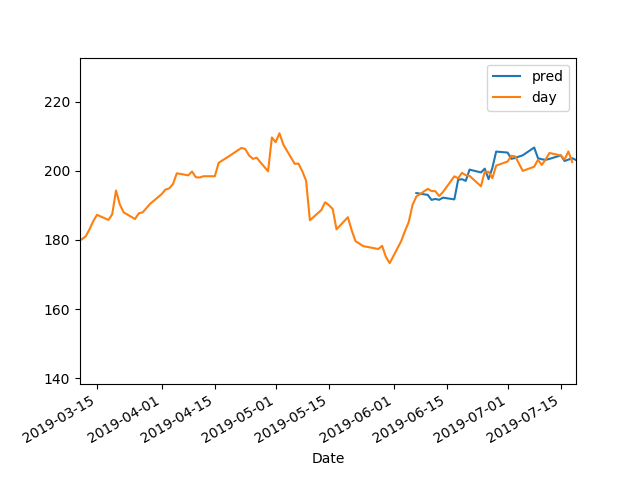

In [63]:
pd4.plot()

Accuracy=  0.9960117372481142


<IPython.core.display.Javascript object>


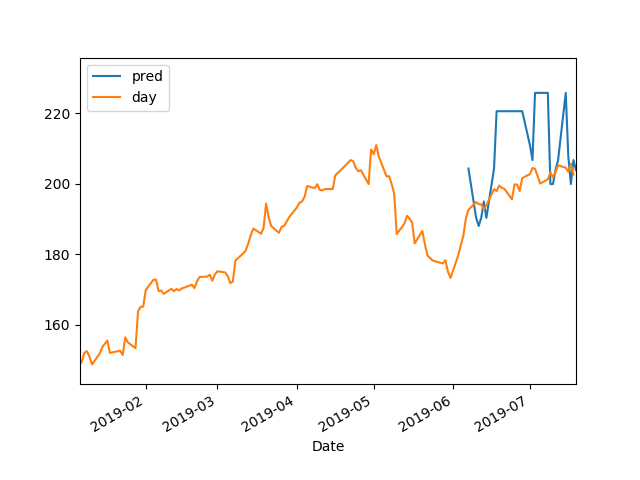

Rolling Cross Validation : [ 0.0679737  -0.16665872 -0.53808193 -1.31352637 -0.61320561 -2.82564961
 -6.48630398 -0.57697826]


In [64]:
from sklearn import tree
from sklearn.tree import plot_tree
clf=tree.DecisionTreeRegressor()
clf.fit(xt,yt)
print("Accuracy= ",clf.score(xte,yte))
pred=np.array(clf.predict(stest))
pd4=pd.DataFrame(pred,index=stest.index,columns=['pred'])
pd4=pd4.join(f.day,how='outer')
pd4.plot()
result=cross_val_score1(clf,X,Y,8)
print("Rolling Cross Validation :",result)

In [65]:
import numpy as np
from sklearn.metrics import classification_report,f1_score, precision_score, recall_score, accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib notebook
X=np.array((selectedFC))
Y=np.array((label1['DailyRE']))
xt,xte,yt,yte=train_test_split(X,Y)



In [68]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
clf=neighbors.KNeighborsClassifier()
clf.fit(xt,yt)
print("Accracy = ",clf.score(xte,yte))
pred=clf.predict(xte)
print("Rolling Cross Validation :     ",(cross_val_score1(neighbors.KNeighborsClassifier(),X,Y,cv=8)).mean())
print(classification_report(yte,pred))

Accracy =                         0.7468146321413892
Rolling Cross Validation :      0.733695652173913
              precision    recall  f1-score   support

          -1       0.73      0.76      0.75      1181
           1       0.77      0.73      0.75      1252

    accuracy                           0.75      2433
   macro avg       0.75      0.75      0.75      2433
weighted avg       0.75      0.75      0.75      2433



In [69]:
from sklearn.naive_bayes import BernoulliNB
clf=BernoulliNB()
clf.fit(xt,yt)
print("accuracy  :     ",clf.score(xte,yte))
pred=clf.predict(xte)
print("Rolling Cross Validation :     ",(cross_val_score1(BernoulliNB(),X,Y,cv=8)).mean())
print(classification_report(yte,pred))

accuracy  :      0.6555692560624743
Rolling Cross Validation :      0.6645467160037002
              precision    recall  f1-score   support

          -1       0.65      0.63      0.64      1181
           1       0.66      0.68      0.67      1252

    accuracy                           0.66      2433
   macro avg       0.66      0.65      0.65      2433
weighted avg       0.66      0.66      0.66      2433



In [71]:
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.metrics import confusion_matrix
clf=RandomForestClassifier()
clf.fit(xt,yt)
print("accuracy :  ",clf.score(xte,yte))
pred=clf.predict(xte)
print("Rolling Cross Validation :     ",(cross_val_score1(RandomForestClassifier(),X,Y,cv=8)).mean())
print(classification_report(yte,pred))

C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy :   0.8594327990135635


C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Rolling Cross Validation :      0.8185707678075855
              precision    recall  f1-score   support

          -1       0.83      0.89      0.86      1181
           1       0.89      0.83      0.86      1252

    accuracy                           0.86      2433
   macro avg       0.86      0.86      0.86      2433
weighted avg       0.86      0.86      0.86      2433



In [72]:
from sklearn import svm
clf=svm.SVC(kernel='linear')
clf.fit(xt,yt)
print("Accracy=  ",clf.score(xte,yte))
pred=clf.predict(xte)
print("Rolling Cross Validation :     ",(cross_val_score1(svm.SVC(kernel='linear'),X,Y,cv=8)).mean())
print(classification_report(yte,pred))

Accracy=   0.9251952322235922
Rolling Cross Validation :      0.9219472710453285
              precision    recall  f1-score   support

          -1       0.92      0.93      0.92      1181
           1       0.93      0.92      0.93      1252

    accuracy                           0.93      2433
   macro avg       0.93      0.93      0.93      2433
weighted avg       0.93      0.93      0.93      2433



In [73]:
from sklearn.ensemble import AdaBoostClassifier
clf= AdaBoostClassifier(n_estimators=100)
clf.fit(xt,yt)
print("Accuracy=  ",clf.score(xte,yte))
pred=clf.predict(xte)
print("Rolling Cross Validation :     ",(cross_val_score1(AdaBoostClassifier(n_estimators=100),X,Y,cv=8)).mean())
print(classification_report(yte,pred))

Accuracy=   0.9116317303740238
Rolling Cross Validation :      0.8787002775208141
              precision    recall  f1-score   support

          -1       0.91      0.91      0.91      1181
           1       0.91      0.92      0.91      1252

    accuracy                           0.91      2433
   macro avg       0.91      0.91      0.91      2433
weighted avg       0.91      0.91      0.91      2433



In [76]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(n_jobs=-1)
clf.fit(xt,yt)
print("Accuracy = ",clf.score(xte,yte))
pred=clf.predict(xte)
print("Rolling Cross Validation :     ",(cross_val_score1(LogisticRegression(n_jobs=-1),X,Y,cv=8)).mean())
print(classification_report(yte,pred))

C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver w

Accuracy =  0.9243732018084669
Rolling Cross Validation :      0.9183626271970398
              precision    recall  f1-score   support

          -1       0.92      0.92      0.92      1181
           1       0.93      0.92      0.93      1252

    accuracy                           0.92      2433
   macro avg       0.92      0.92      0.92      2433
weighted avg       0.92      0.92      0.92      2433



C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [80]:

from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import plot_tree
%matplotlib notebook
clf=tree.DecisionTreeClassifier()
clf.fit(xt,yt)
print("Accuracy=  ",clf.score(xte,yte))
pred=clf.predict(xte)
print("Rolling Cross Validation :     ",(cross_val_score1(tree.DecisionTreeClassifier(),X,Y,cv=8)).mean())
print(classification_report(yte,pred))

Accuracy=   0.9556103575832305
Rolling Cross Validation :      0.8814754856614246
              precision    recall  f1-score   support

          -1       0.96      0.95      0.95      1181
           1       0.96      0.96      0.96      1252

    accuracy                           0.96      2433
   macro avg       0.96      0.96      0.96      2433
weighted avg       0.96      0.96      0.96      2433



In [81]:
from sklearn.ensemble  import VotingClassifier
clf=VotingClassifier([('tree',tree.DecisionTreeClassifier()),('log',LogisticRegression()),
                      ('svm',svm.SVC(kernel='linear')),('rnf',RandomForestClassifier()),
                      ('Ada',AdaBoostClassifier(n_estimators=100))])
clf.fit(xt,yt)
print("Accuracy =",clf.score(xte,yte))
pred=clf.predict(xte)
print("Rolling Cross Validation :     ",(cross_val_score1(clf,X,Y,cv=8)).mean())

print(classification_report(yte,pred))

C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy = 0.9482120838471023


C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed

Rolling Cross Validation :      0.9235661424606845
              precision    recall  f1-score   support

          -1       0.94      0.95      0.95      1181
           1       0.95      0.95      0.95      1252

    accuracy                           0.95      2433
   macro avg       0.95      0.95      0.95      2433
weighted avg       0.95      0.95      0.95      2433



From the above results , it can be concluded that predicting the movement of stock price (Classification approach ) yield better results in rolling cross validation,thus is more reliable. As compared to predicting price (Regression approach) which yields better results in accuracy but performs very poorly when it comes to rolling cross validation.